# Data Mining / Prospecção de Dados

## Sara C. Madeira and André Falcão, 2019/20

# Project 1 - Pattern Mining

## Logistics

**In a "normal" scenario students should work in teams of 2 people. Due to the social distance imposed by current public health situation, students were allowed to work in groups of 1 and 3. In this context, the amount of work was adapted according to the number of students in groups as described below.**

* Task **1.** should be done by **all** groups
* Task **2.1.** should be done by **all** groups
* Task **2.2.** should be done only by **groups of 2 and 3** students
* Task **2.3** should be done only by **groups of 2 and 3** students
* Task **2.4** should be done only by **groups of 3** students
* Task **2.5** should be done only by **groups of 3** students

The quality of the project will then dictate its grade.

**The project's solution should be uploaded in Moodle before the end of April, 26th 2020 (23:59).** 

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. Note that you can use `PD_201920_Project.ipynb`as template.**

Students should **upload a `.zip` file** containing all the files necessary for project evaluation. 

**Decisions should be justified and results should be critically discussed.**

## Dataset and Tools

In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and **[MLxtend](http://rasbt.github.io/mlxtend/)**. When using MLxtend, frequent patterns can either be discovered using `Apriori` and `FP-Growth`. **Choose the pattern mining algorithm to be used.** 

The dataset to be analysed is **`Foodmart_2020_PD.csv`**, a modified version of the [Foodmart 2000(2005) dataset](https://github.com/neo4j-examples/neo4j-foodmart-dataset/tree/master/data). 

**`Foodmart_2020_PD.csv`** stores **69549 transactions** from **24 stores**, where **103 different products** can be bought. Each transaction (row) has a STORE_ID (integer from 1 to 24), and a list of products (items), together with the quantities bought. In the transation highlighted below, a customer bought 1 unit of soup, 2 of cheese and 1 of wine at store 2.

<img src="Foodmart_2020_PD_Example.png" alt="Foodmart_2020_PD_Example" style="width: 1000px;"/>

**In what follows keep the following question in mind and be creative!**

1. What are the most popular products?
2. Which products are bought together?
3. Can you find associations highliting that when people buy a product/set of products also buy other product(s)?

## 0. Imports

Imports are done here

In [1]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, fpgrowth

## 1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores

In this first part of the project you should load and preprocessed the dataset **`Foodmart_2020_PD.csv`** in order to compute frequent itemsets and generate association rules considering all the transactions, regardeless of the store, and ignoring product quantities.

### 1.1. Load and Preprocess Dataset

 **Product quantities and stores should not be considered.**

Load the data

In [2]:
itemset = pd.read_csv('./data/Foodmart_2020_PD.csv', delimiter = ';')
itemset.shape

(69549, 11)

Our dataset consists of 69549 transactions 

In [3]:
itemset.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11
0,STORE_ID=2,Pasta=3,Soup=2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,STORE_ID=2,Soup=1,Fresh Vegetables=3,Milk=3,Plastic Utensils=2,NaN,NaN,NaN,NaN,NaN,NaN
2,STORE_ID=2,Cheese=2,Deodorizers=1,Hard Candy=2,Jam=2,NaN,NaN,NaN,NaN,NaN,NaN
3,STORE_ID=2,Fresh Vegetables=2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,STORE_ID=2,Cleaners=1,Cookies=2,Eggs=2,Preserves=1,NaN,NaN,NaN,NaN,NaN,NaN


**Preprocessing**

In [4]:
preprocessing = False
preprocessed_data_path = 'data/data_preprocessed.npy'

In [5]:
def clear_quantities(x):
    if isinstance(x,str):
        item = x.split('=')
        return item[0]
    else:
        return x

Remove store column from dataset and clear quantities.

In [6]:
if preprocessing == True:
    #remove store column
    itemset = itemset.loc[:,'Column2':'Column11']
    #clear quantities
    itemset = itemset.applymap(clear_quantities)

Remove nan values 

In [8]:
if preprocessing == True:
    
    #remove nan values
    transactions_cleaned = []
    for i, t in enumerate(itemset.values):
        transaction = []
        for v in t:
            if isinstance(v,str): transaction.append(v)
        transactions_cleaned.append(transaction)
        
    #save preprocessed data 
    np.save(preprocessed_data_path,np.array(transactions_cleaned))
    
#load the data
else: transactions_cleaned = np.load(preprocessed_data_path, allow_pickle = True)

Apply transaction encoder

In [9]:
te = TransactionEncoder()
te_ary = te.fit(transactions_cleaned).transform(transactions_cleaned)
df_te = pd.DataFrame(te_ary, columns=te.columns_)
df_te.head()

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Most frequent products**

Compute the most frequent products

In [10]:
df_products_frequency = pd.DataFrame()
for c in df_te.columns:
    df_c = df_te[c].value_counts().to_frame('count').reset_index()
    total = int(df_c[df_c['index'] == True]['count'])
    df_products_frequency = df_products_frequency.append({'product':c,'total': total,'support':(total/len(itemset))},ignore_index = True)
df_products_frequency = df_products_frequency.sort_values('total',ascending = False)
df_products_frequency.head()

,product,support,total
40,Fresh Vegetables,0.284174,19764.0
39,Fresh Fruit,0.175229,12187.0
86,Soup,0.120059,8350.0
12,Cheese,0.117802,8193.0
31,Dried Fruit,0.117212,8152.0


Compute some statistic metrics about the total column

In [13]:
df_products_frequency.total.describe()

count      102.000000
mean      2834.500000
std       2589.666372
min        895.000000
25%        971.000000
50%       1991.000000
75%       3747.500000
max      19764.000000
Name: total, dtype: float64

We can see that on average each product appears in 2834 transactions. The less bought product appears in 895 transactions, and the most bought product appears in 19764 transactions.

Now lets plot the 20 most frequent bought products

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

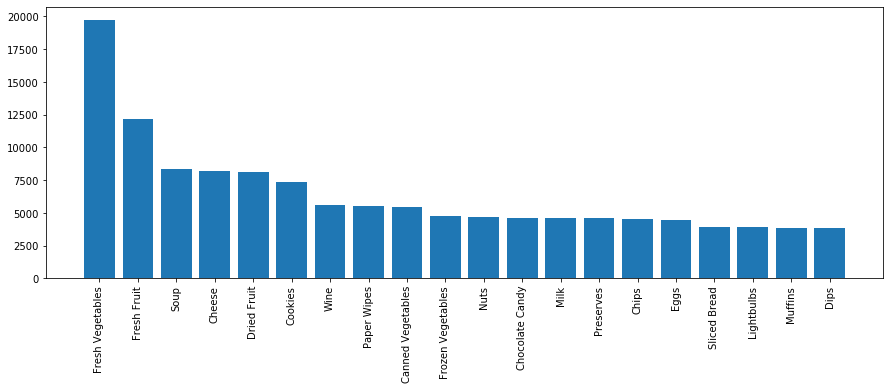

In [14]:
plt.figure(figsize=(15,5))
df_graph = df_products_frequency.iloc[:20]
plt.bar(df_graph['product'],df_graph['total'])
plt.xticks(rotation=90)

The product that appears in most transactions is 'Fresh Vegatables', which has a support of +- 0.28 (meaning that appears in 28% of the transactions).

### 1.2. Compute Frequent Itemsets

* Compute frequent itemsets considering a minimum support of X%. 
* Present frequent itemsets organized by length (number of items). 
* List frequent 1-itemsets, 2-itemsets, 3-itemsets, etc with support of at least Y%.
* Change X and Y when it makes sense and discuss the results.

### 1.2.1 Using apriori algorithm

In [16]:
%timeit frequent_itemsets  = apriori(df_te, min_support=0.005, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values('support',ascending = False)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets['num_transactions'] = [round(s*len(itemset)) for s in frequent_itemsets['support']]

7.29 s ± 534 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NameError: name 'frequent_itemsets' is not defined

In [ ]:
frequent_itemsets[frequent_itemsets['num_items'] == 1]

In [ ]:
frequent_itemsets[frequent_itemsets['num_items'] == 2]

In [ ]:
frequent_itemsets[frequent_itemsets['num_items'] == 3]

#### 1.2.2 Using FP-Growth

In [ ]:
%timeit frequent_itemsets_fpg  = fpgrowth(df_te, min_support=0.005, use_colnames=True)
frequent_itemsets_fpg = frequent_itemsets_fpg.sort_values('support',ascending = False)
frequent_itemsets_fpg['length'] = frequent_itemsets_fpg['itemsets'].apply(lambda x: len(x))
frequent_itemsets_fpg['num_transactions'] = [round(s*len(itemset)) for s in frequent_itemsets_fpg['support']]

In [ ]:
frequent_itemsets_fpg[frequent_itemsets['num_items'] == 1]

In [ ]:
frequent_itemsets_fpg[frequent_itemsets['num_items'] == 2]

In [ ]:
frequent_itemsets_fpg[frequent_itemsets['num_items'] == 3]

### 1.3. Generate Association Rules from Frequent Itemsets

* Generate association rules with a minimum confidence of C%. 
* Generate association rules with a minimum lift L. 
* Generate association rules with both confidence >= % and lift >= 1.1.
* Change C and L when it makes sense and discuss the results.

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this ...


### 1.4. Take a Look at Maximal Patterns: Compute Maximal Frequent Itemsets

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this ...


### 1.5 Conclusions from Mining Frequent Patterns in All Stores

Write text in cells like this ...


## 2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores

The 24 stores, whose transactions were analysed in Task 1, are in fact **different types of stores**:
* Deluxe Supermarkets: STORE_ID = 8, 12, 13, 17, 19, 21
* Gourmet Supermarkets: STORE_ID = 4, 6
* Mid-Size Grocerys: STORE_ID = 9, 18, 20, 23
* Small Grocerys: STORE_ID = 2, 5, 14, 22
* Supermarkets: STORE_ID = 1, 3, 7, 10, 11, 15, 16

In this context, in this second task you should compute frequent itemsets and association rules for specific groups of stores, and then compare the store specific results with those obtained when all transactions were analysed independently of the type of store. 

**The goal is to find similarities and differences in buying patterns according to the types of store. Do popular products change? Are there buying patterns specific to the type of store?**

### 2.1. Analyse Deluxe Supermarkets and Gourmet Supermarkets

Here you should analyse transactions from **Deluxe Supermarkets (STORE_ID = 8, 12, 13, 17, 19, 21) and Gourmet Supermarkets (STORE_ID = 4, 6) together**.

#### 2.1.1. Load/Preprocess the Dataset

**You might need to change a bit the preprocessing, although most of it should be reused.**

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this ...


#### 2.1.2. Compute Frequent Itemsets

**This should be trivial now.**

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this ...


#### 2.1.3. Generate Association Rules from Frequent Itemsets

**This should be trivial now.**

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this 


#### 2.1.4.  Deluxe/Gourmet Supermarkets versus All Stores

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets).

Write text in cells like this 


### 2.2. Analyse Small Groceries [For groups of 2 and 3]

Here you should analyse **Small Groceries (STORE_ID = 2, 5, 14, 22)**.

#### 2.2.1.  Load/Preprocess the Dataset

**This should be trivial now.**

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this 


#### 2.2.2. Compute Frequent Itemsets

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this 


#### 2.2.3. Generate Association Rules from Frequent Itemsets

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this


#### 2.2.4 Small Groceries versus All Stores

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only Small Groceries).

Write text in cells like this


### 2.3.  Deluxe/Gourmet Supermarkets versus Small Groceries  [For groups of 2 and 3]

Discuss the similarities and diferences between the results obtained in task 2.1. (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets) and those obtained in task 2.2. (frequent itemsets and association rules found in transactions only Small Groceries).

In [ ]:
# Write code in cells like this
# ....

### 2.4. Analyse Supermarkets [Only for groups of 3]
Here you should analyse Supermarkets (STORE_ID = 1, 3, 7, 10, 11, 15, 16).

Use subsections as in tasks 2.1 and 2.2.



In [ ]:
# Write code in cells like this
# ....

### 2.5. Deluxe/Gourmet Supermarkets versus Supermarkets [Only for groups of 3]
Discuss the similarities and diferences between the results obtained in task 2.1. (frequent itemsets and association rules found in transactions from Deluxe Supermarkets/Gourmet Supermarkets) and the results obtained in task 2.4. (frequent itemsets and association rules found in transactions from Supermarkets).

Write text in cells like this

In [ ]:
# Write code in cells like this
# ....